# Import and Config

In [1]:
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz.config import *
from discofuzz.WiCDatasetHandler import WiCDatasetHandler
from discofuzz.BaseEmbeddingModel import BaseEmbeddingModel
from discofuzz.DisCoFuzz import DisCoFuzz
from discofuzz.EvalHarness import EvalHarness

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [3]:
sample_size = 100
# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
n_components = 64
fuzzification_kernel_size = 16

# load config vars or defaults
X_train, y_train, X_test, y_test = WiCDatasetHandler.load_dataset(".")
X_train, y_train, X_test, y_test = X_train[:sample_size], y_train[:sample_size], X_test[:sample_size], y_test[:sample_size]
sim_metrics = [s.value for s in sim_metrics_enum]
embedding_model = BaseEmbeddingModel()
model = DisCoFuzz(embedding_model)
eval_harness = EvalHarness(
    sim_metrics=sim_metrics_enum,
    composition_strategies=STRATEGIES,
    embedding_model=embedding_model,
    spacy_model=model.spacy_model,
    fuzzifier=model.lemma_vectorizer.fuzzifier,
)

# Run model

In [4]:
sents = X_train["sent_1"].to_list() + X_train["sent_2"].to_list()
embedding_model.fit_transform(sents)

array([[ 0.19946899, -0.14903253, -0.00362449, ...,  0.010806  ,
        -0.00896521, -0.11389648],
       [ 0.13666089,  0.04740518, -0.21337496, ...,  0.07616261,
        -0.11181338,  0.02176107],
       [ 0.3162496 ,  0.03346251,  0.14219253, ...,  0.0630914 ,
        -0.15638717,  0.1160095 ],
       ...,
       [-0.30711922, -0.19840205, -0.0138683 , ...,  0.0965261 ,
        -0.07688244,  0.01969808],
       [ 0.05111901, -0.09810484, -0.33803904, ...,  0.09894645,
        -0.0260341 ,  0.09326763],
       [-0.17815691,  0.09907639, -0.10336677, ..., -0.14963683,
        -0.01152115,  0.01220706]], dtype=float32)

In [5]:
X_train = model.fit(X_train)
X_train = model.predict_batch(X_train, STRATEGIES)

	Composing embeddings with mean approach...
	Composing embeddings with intersection+mean approach...
	Composing embeddings with intersection+union approach...
	Composing embeddings with intersection+intersection approach...
	Composing embeddings with selective_intersection+mean approach...
	Composing embeddings with selective_intersection+union approach...
	Composing embeddings with selective_intersection+intersection+mean approach...


# Evaluate model

In [6]:
eval_harness.fit(X_train)
sims_df = eval_harness.get_similarities(X_train)
sims_df.head()


	=== Computing similarities with cos metric ===
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...
		Getting compositional embedding relatedness scores for baseline_sent approach...
		Getting compositional embedding relatedness scores for baseline_tok approach...

	=== Computing similarities with wasserstein-1 metric ===
		Getting compositional embedding relatedness scores for mean approach...
		Ge

,fuzzy_mean_cos_sim,fuzzy_intersection+mean_cos_sim,fuzzy_intersection+union_cos_sim,fuzzy_intersection+intersection_cos_sim,fuzzy_selective_intersection+mean_cos_sim,fuzzy_selective_intersection+union_cos_sim,fuzzy_selective_intersection+intersection+mean_cos_sim,fuzzy_baseline_sent_cos_sim,fuzzy_baseline_tok_cos_sim,fuzzy_mean_wasserstein-1_sim,...,fuzzy_intersection+mean_quantum_sim,fuzzy_intersection+union_quantum_sim,fuzzy_intersection+intersection_quantum_sim,fuzzy_selective_intersection+mean_quantum_sim,fuzzy_selective_intersection+union_quantum_sim,fuzzy_selective_intersection+intersection+mean_quantum_sim,fuzzy_baseline_sent_quantum_sim,fuzzy_baseline_tok_quantum_sim,baseline_sent_cos_sim,baseline_tok_cos_sim
0,0.109690,0.000701,0.001016,0.001016,0.021092,0.011593,0.021092,-0.090479,-0.070963,-0.056405,...,-0.014710,-0.007335,-0.007335,0.014349,-0.000745,0.014349,-0.157573,-0.032408,-0.187282,-0.174033
1,0.070016,-0.009302,-0.000635,-0.000635,0.009011,0.001132,0.009011,-0.166111,-0.026772,0.016099,...,0.007452,0.004125,0.004125,0.034167,0.008163,0.034167,-0.160061,0.014075,-0.171496,-0.037694
2,-0.685823,0.009707,0.007633,0.007633,0.003601,0.006353,0.003601,0.105622,-0.376245,-0.353137,...,-0.017844,-0.010492,-0.010492,-0.015516,-0.008992,-0.015516,-0.011763,-0.306729,-0.115290,-0.419186
3,-0.101896,-0.003545,-0.001233,-0.001233,-0.738826,-0.312967,-0.738826,0.043163,-0.082979,-0.065816,...,0.014188,0.004895,0.004895,-0.514246,-0.120674,-0.514246,-0.067072,-0.060139,-0.142031,-0.218919
4,0.230983,0.098280,0.033604,0.033604,-0.730736,-0.336270,-0.730736,0.128204,0.043836,0.313698,...,-0.136492,-0.049029,-0.049029,-0.491313,-0.128461,-0.491313,0.487650,0.041146,0.459272,0.237987


In [7]:
sim_eval_df = eval_harness.classify_similarities(sims_df)

# Visualizations

## Custom similarities vs cosine similarity in original space

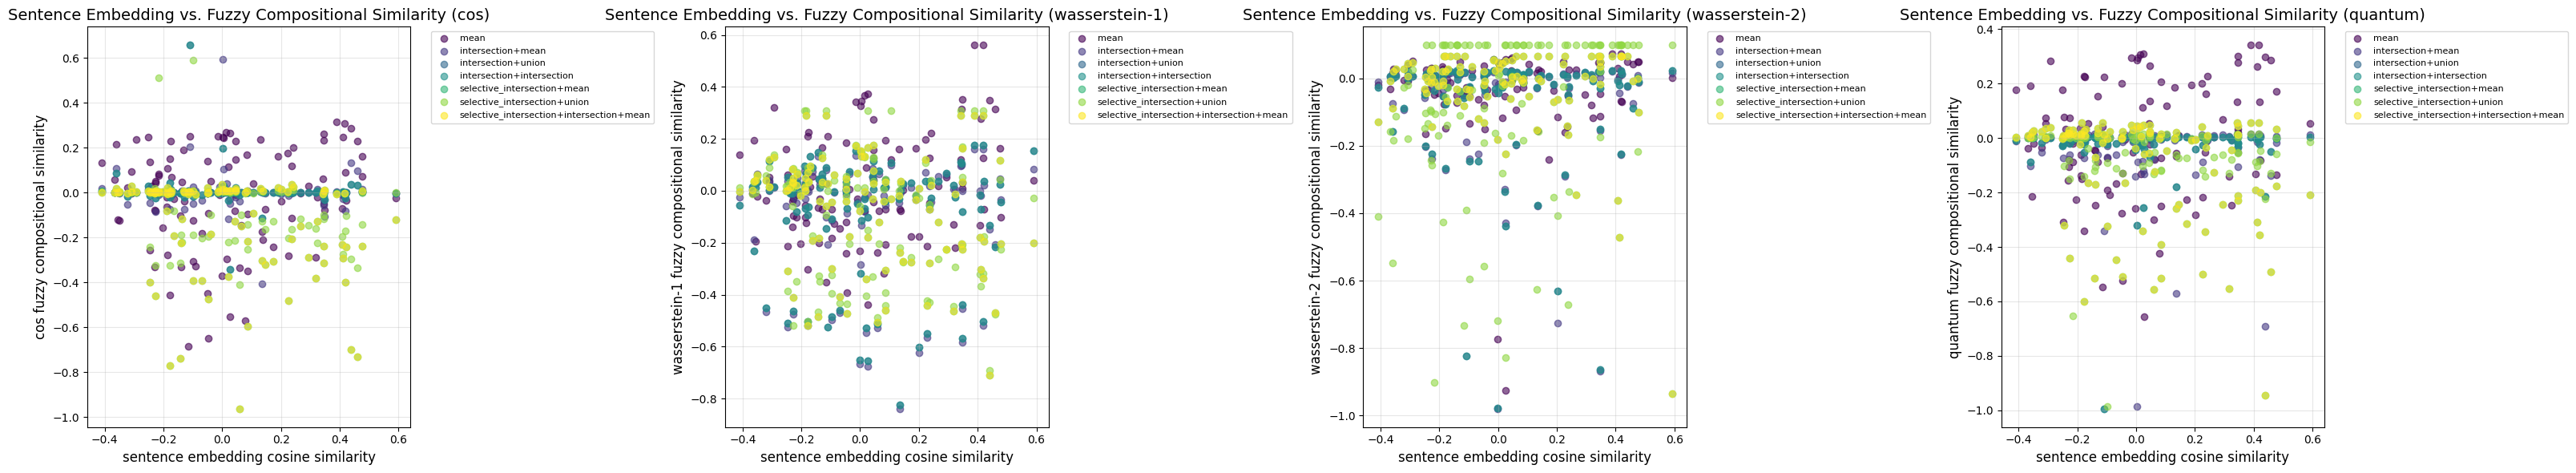

In [8]:
eval_harness.visualize_similarities(sims_df)

## Confusion Matrices

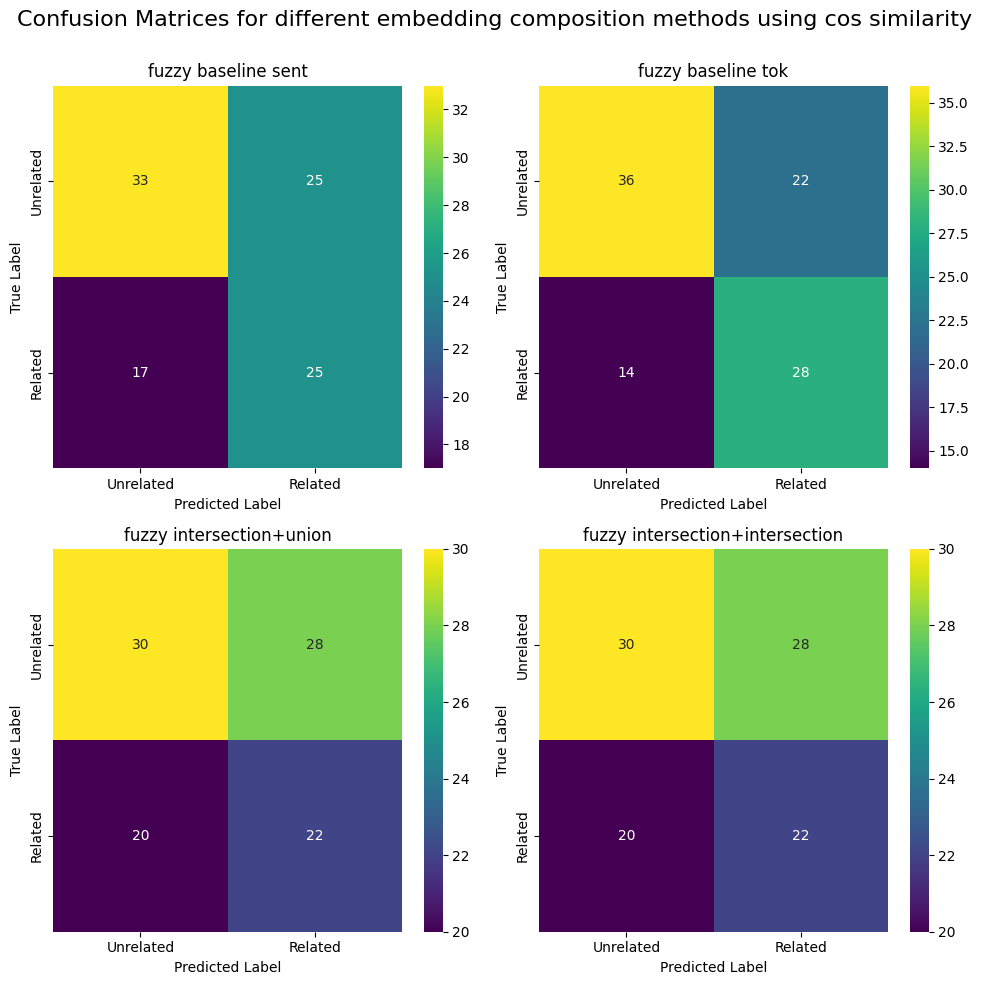

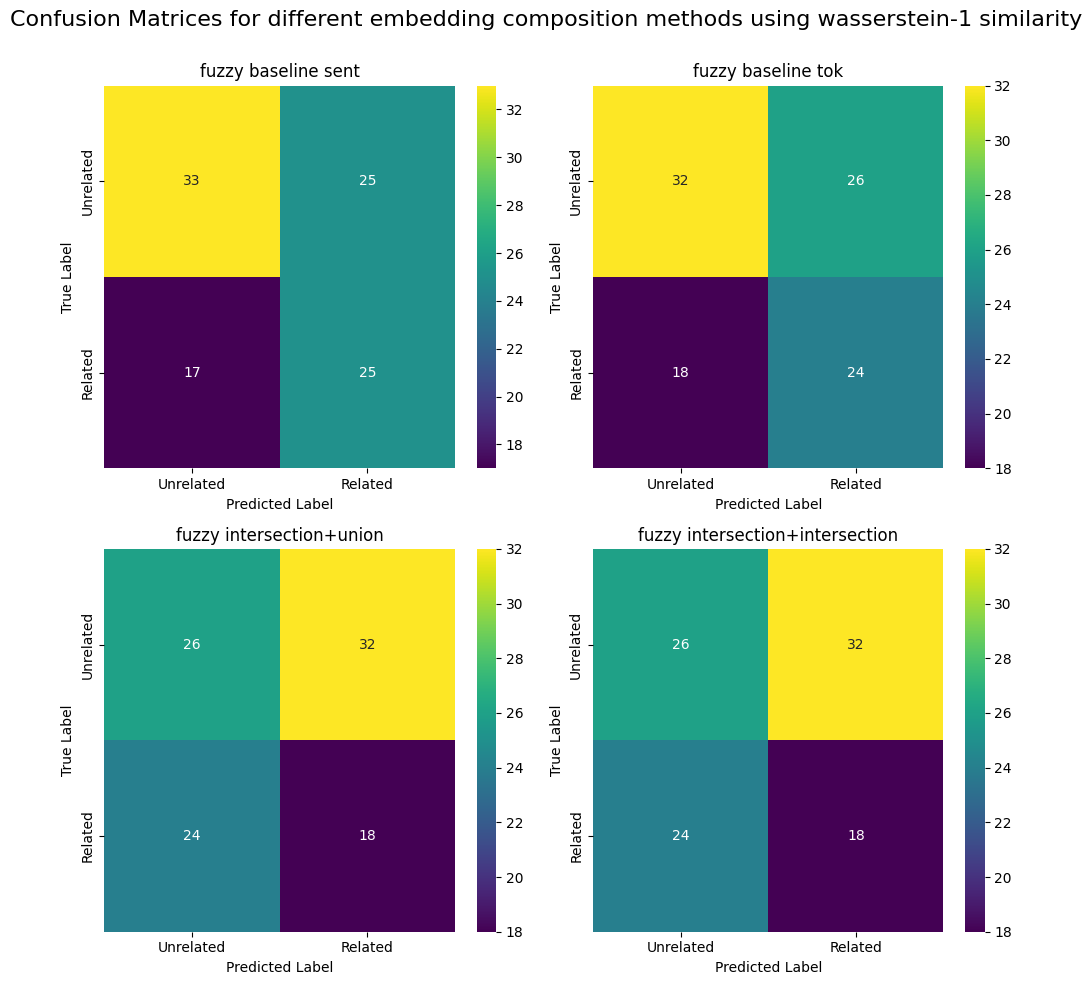

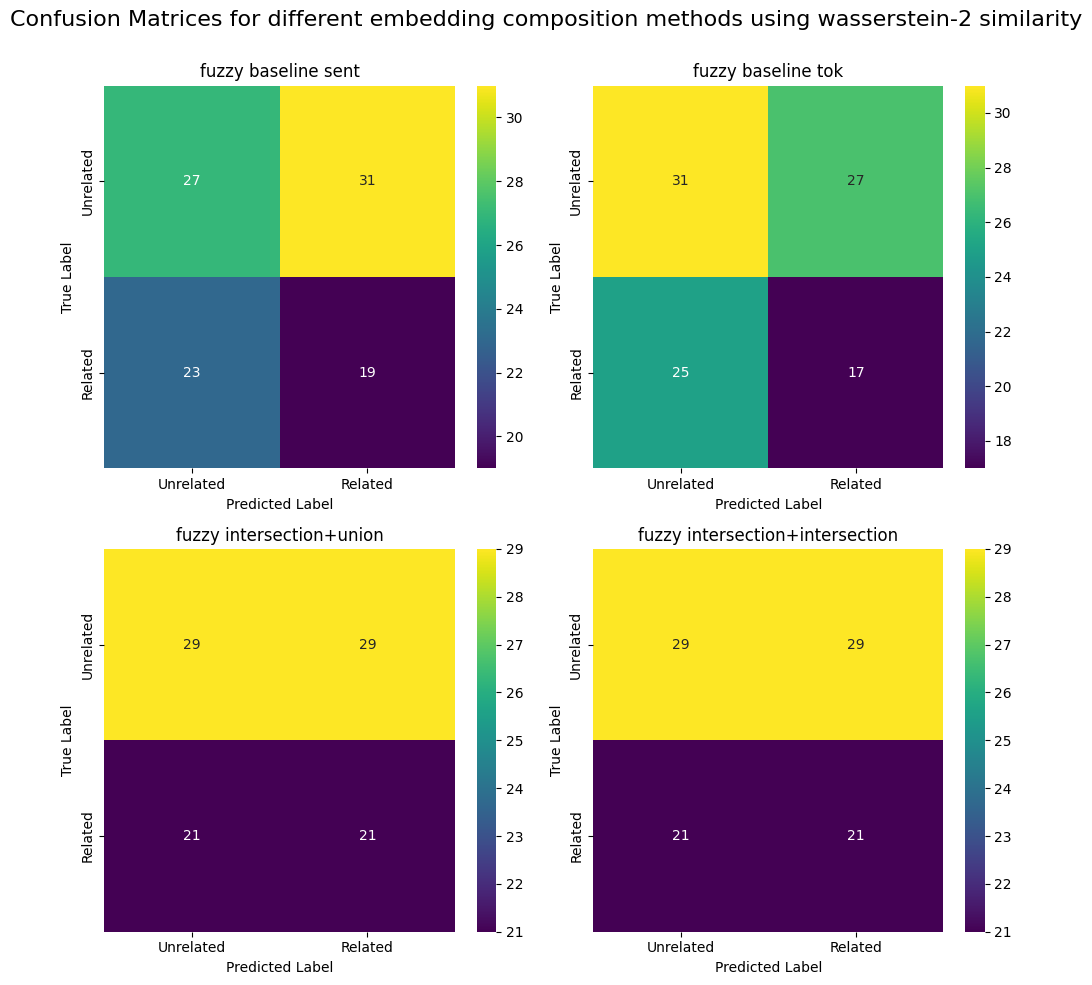

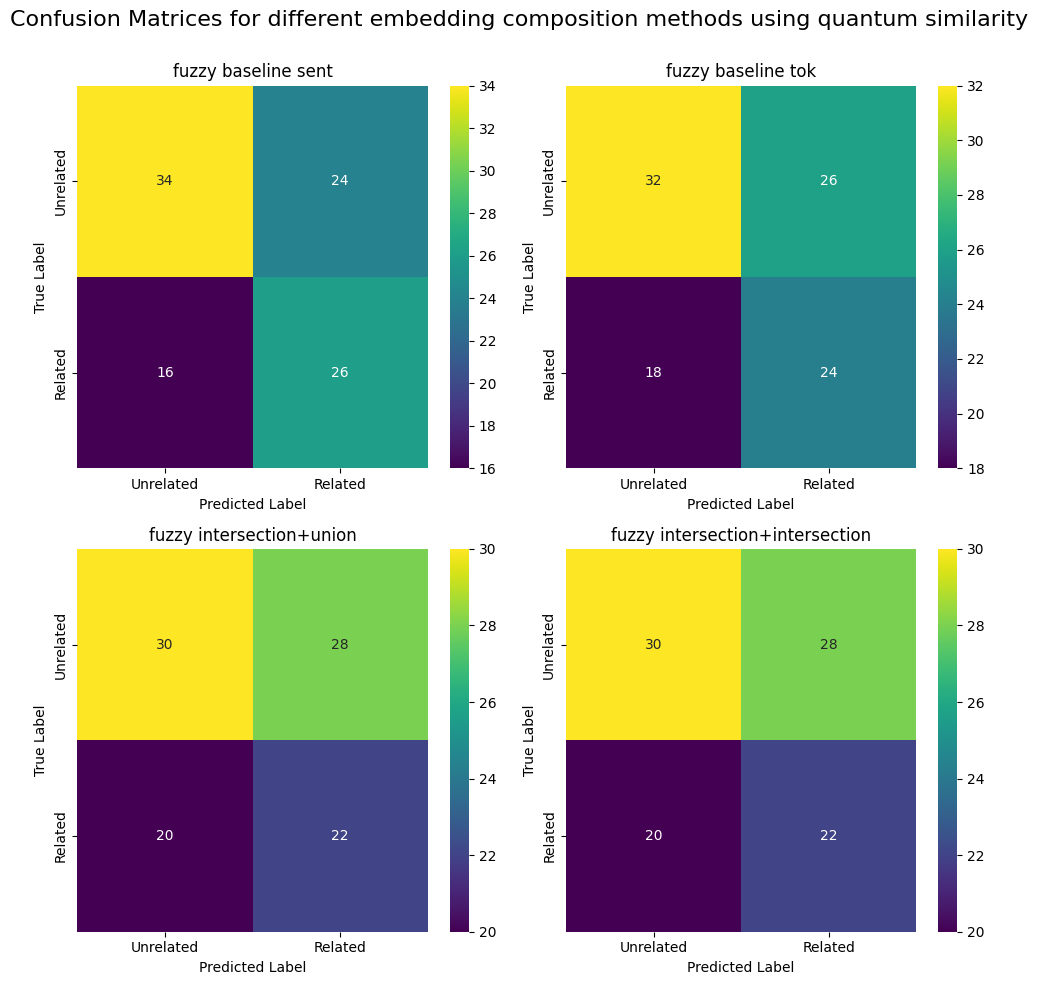

In [9]:
models = [
    "baseline_sent",
    "baseline_tok",
    "intersection+union",
    "intersection+intersection",
]
metric_cols = []
for sim_metric in sim_metrics:
    metric_cols.extend([
        f"fuzzy_{model}_{sim_metric}_sim_pred"
        for model in models
    ])
eval_harness.plot_confusion_matrices(
    X=sim_eval_df[metric_cols],
    y=y_train
)

# Evaluation Results

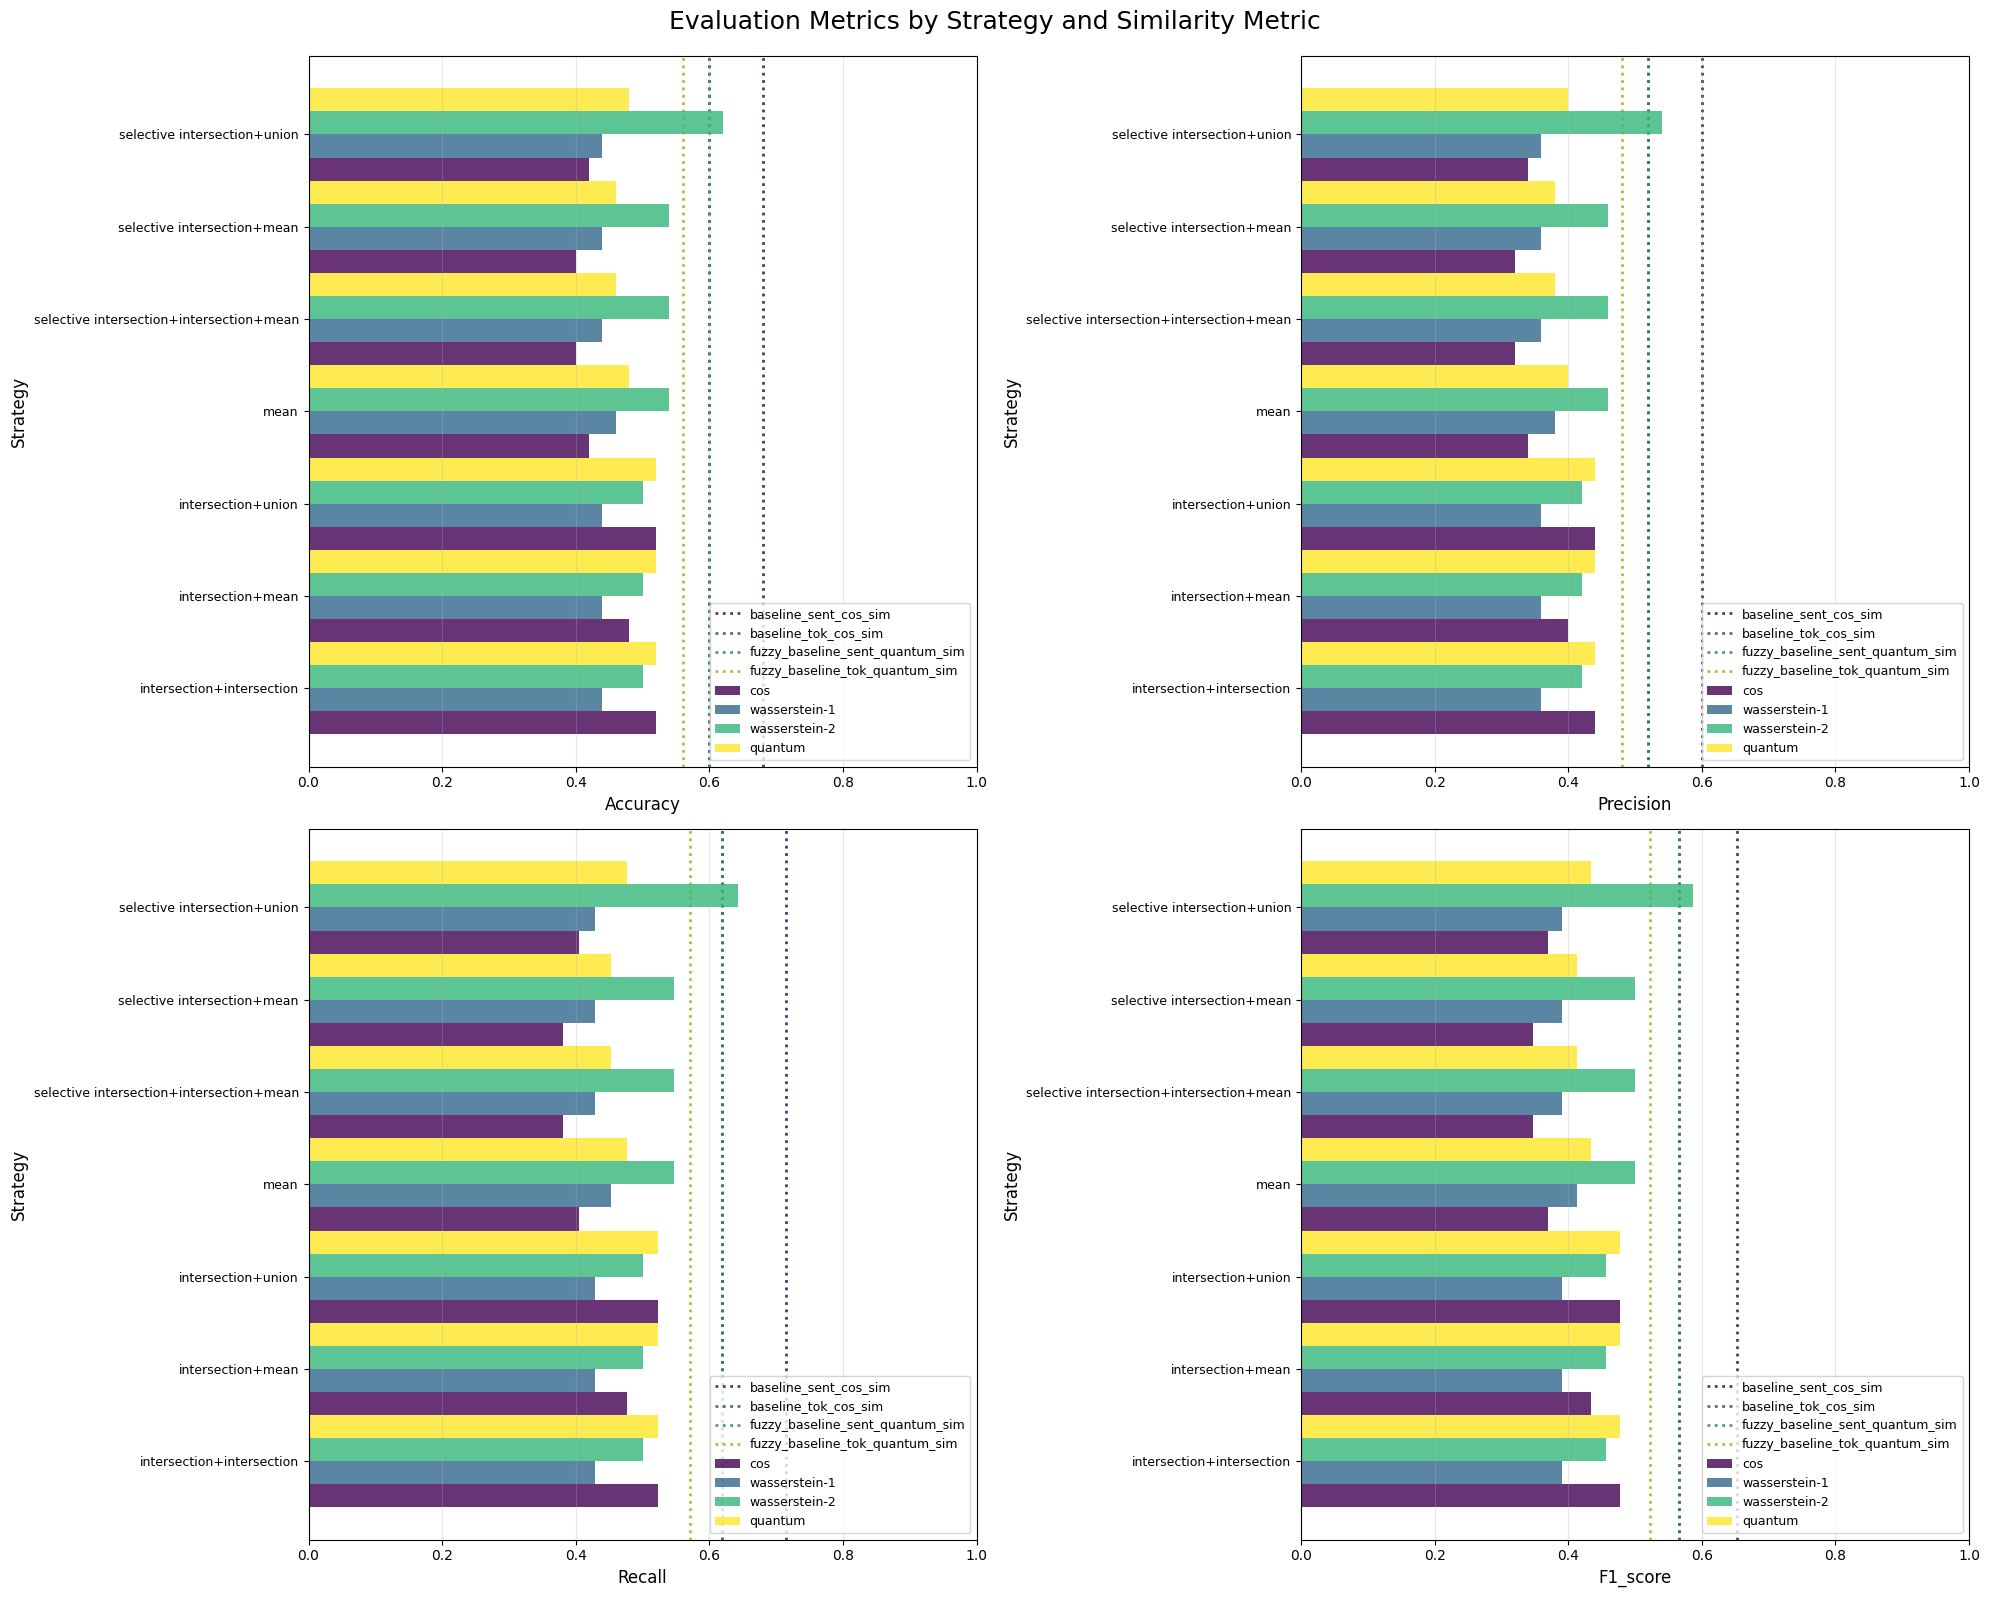

,strategy,similarity_metric,model,accuracy,precision,recall,f1_score
0,baseline_sent,cos,baseline_sent_cos_sim,0.68,0.60,0.714286,0.652174
1,baseline_tok,cos,fuzzy_baseline_tok_cos_sim,0.64,0.56,0.666667,0.608696
2,selective_intersection+union,wasserstein-2,fuzzy_selective_intersection+union_wasserstein...,0.62,0.54,0.642857,0.586957
3,baseline_tok,cos,baseline_tok_cos_sim,0.60,0.52,0.619048,0.565217
4,baseline_sent,quantum,fuzzy_baseline_sent_quantum_sim,0.60,0.52,0.619048,0.565217
5,baseline_sent,cos,fuzzy_baseline_sent_cos_sim,0.58,0.50,0.595238,0.543478
6,baseline_sent,wasserstein-1,fuzzy_baseline_sent_wasserstein-1_sim,0.58,0.50,0.595238,0.543478
7,baseline_tok,quantum,fuzzy_baseline_tok_quantum_sim,0.56,0.48,0.571429,0.521739
8,baseline_tok,wasserstein-1,fuzzy_baseline_tok_wasserstein-1_sim,0.56,0.48,0.571429,0.521739
9,mean,wasserstein-2,fuzzy_mean_wasserstein-2_sim,0.54,0.46,0.547619,0.500000


In [10]:
metrics_df = eval_harness.score(sim_eval_df, y_train)
metrics_df[:10]

In [11]:
metrics_df.to_csv(f"full_train_eval-wn_free-n_components={n_components}-kernel_size={fuzzification_kernel_size}.tsv", sep="\t")